<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
from sklearn.metrics import jaccard_score

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-13 05:30:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2020-11-13 05:30:16 (15.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: - ^C
failed with initial frozen solve. Retrying with flexible solve.

CondaError: KeyboardInterrupt



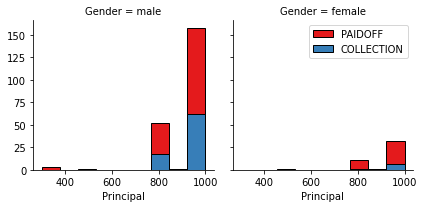

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

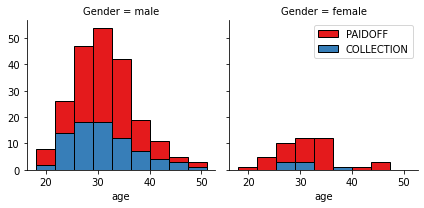

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

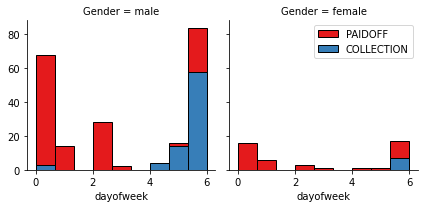

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [74]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Spliting train and test data.
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,random_state=4)

# K values to be tested.
Ks = 10


In [50]:
# Build build a model for each value of k and evaulate it.
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
for k in range(1,Ks):
    KnModel = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yHat = KnModel.predict(X_test)
    yhat=KnModel.predict(X_test)
    mean_acc[k-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[k-1]=np.std(yHat==y_test)/np.sqrt(yHat.shape[0])

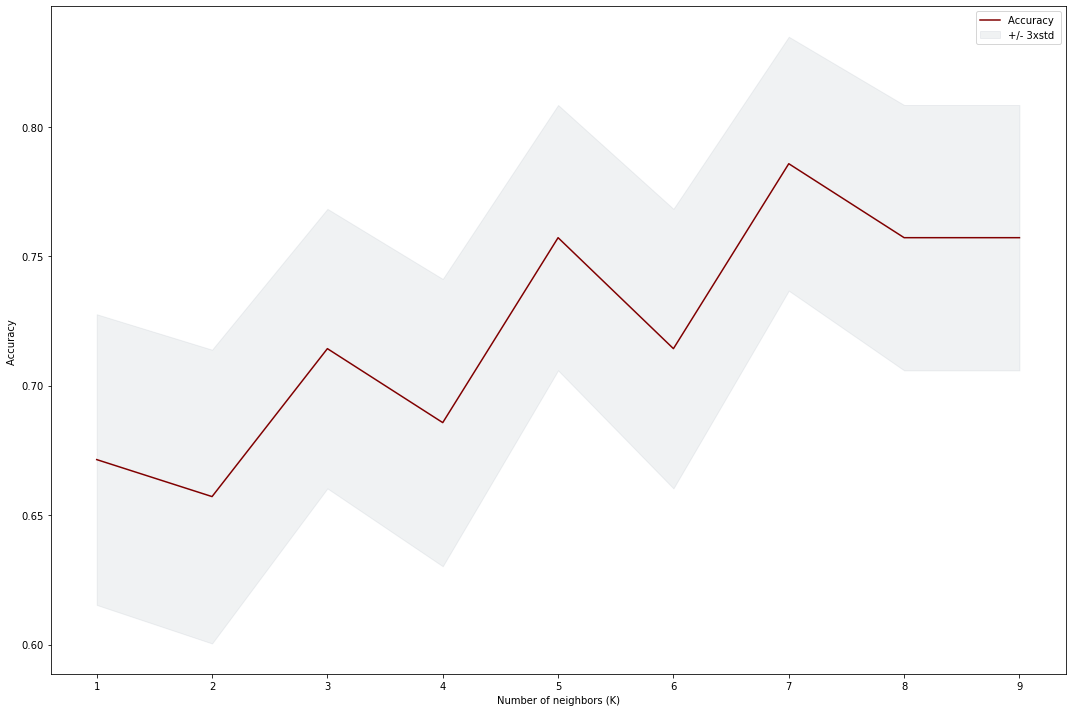

In [55]:
# Plot the results.
plt.figure(figsize=(15,10))
plt.plot(range(1,Ks),mean_acc,"maroon")
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10,color='slategrey')
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of neighbors (K)')
plt.tight_layout()
plt.show()

In [183]:
print("As you can see, the best K value is 7")
bestKnModel = KNeighborsClassifier(n_neighbors = 7).fit(X_train,y_train)

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_train, bestKnModel.predict(X_train),pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, bestKnModel.predict(X_test),pos_label="PAIDOFF"))

print("Train set Accuracy (F1): ", f1_score(y_train, bestKnModel.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, bestKnModel.predict(X_test), average='weighted'))

As you can see, the best K value is 7
Train set Accuracy (Jaccard):  0.7782426778242678
Test set Accuracy (Jaccard):  0.765625
Train set Accuracy (F1):  0.8000194668761034
Test set Accuracy (F1):  0.7766540244416351


# Decision Tree

In [184]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree

For depth 1 the accuracy is 0.7857142857142857
For depth 2 the accuracy is 0.7857142857142857
For depth 3 the accuracy is 0.6142857142857143
For depth 4 the accuracy is 0.6142857142857143
For depth 5 the accuracy is 0.6428571428571429
For depth 6 the accuracy is 0.7714285714285715
For depth 7 the accuracy is 0.7571428571428571
For depth 8 the accuracy is 0.7571428571428571
The best depth is 2


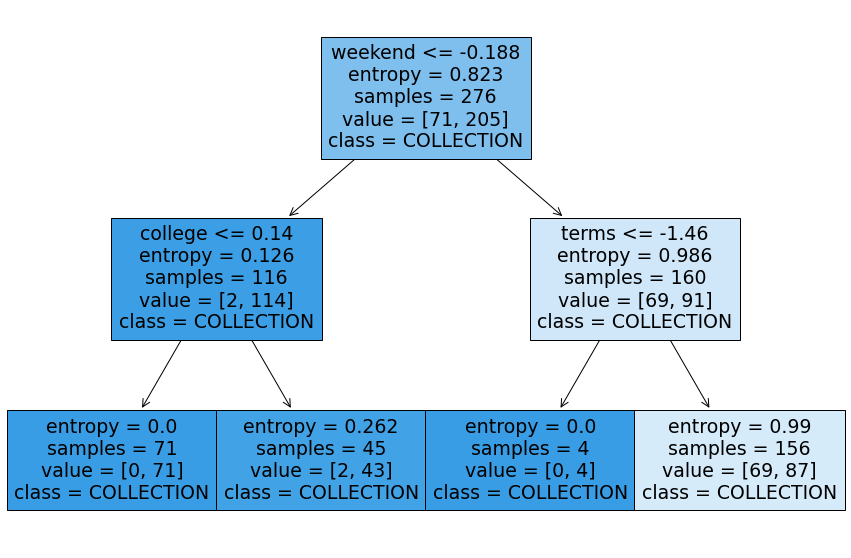

In [196]:
# Build and fit model for each number of classifiers.
classifiers = [i for i in range(1,9)]
accScores = []
for classNum in range(1,9):
    debtTree = DecisionTreeClassifier(criterion="entropy",max_depth=classNum).fit(X_train,y_train)
    yhat = debtTree.predict(X_test)
    accScores.append(metrics.accuracy_score(y_test,yhat))
    print("For depth",classNum,"the accuracy is",metrics.accuracy_score(y_test,yhat))
# Results
print("The best depth is 2")
bestLoanTree = DecisionTreeClassifier(criterion="entropy",max_depth=2).fit(X_train,y_train)
    
# Visualization
plt.figure(figsize=(15,10))
treeGraph = tree.plot_tree(bestLoanTree,feature_names=Feature.columns,class_names=["PAIDOFF","COLLECTION"],filled=True)

In [172]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_train, bestLoanTree.predict(X_train),pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, bestLoanTree.predict(X_test),pos_label="PAIDOFF"))

print("Train set Accuracy (F1): ", f1_score(y_train, bestLoanTree.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, bestLoanTree.predict(X_test), average='weighted'))

Train set Accuracy (Jaccard):  0.7427536231884058
Test set Accuracy (Jaccard):  0.7857142857142857
Train set Accuracy (F1):  0.6331163939859591
Test set Accuracy (F1):  0.6914285714285714


# Support Vector Machine

In [28]:
from sklearn import svm
from sklearn.metrics import f1_score

In [198]:
# Iterate over every style to find the best one.
accScores = []
styles = ['linear', 'poly', 'rbf','sigmoid']
for style in styles:
    svmModel = svm.SVC(kernel = style).fit(X_train,y_train)
    yhat = svmModel.predict(X_test)
    acc = metrics.accuracy_score(y_test,yhat)
    accScores.append(acc)
    
    print("The accuracy of",style,"is",acc)


The accuracy of linear is 0.7857142857142857
The accuracy of poly is 0.7714285714285715
The accuracy of rbf is 0.7428571428571429
The accuracy of sigmoid is 0.7428571428571429


Text(0.5, 0, 'Option')

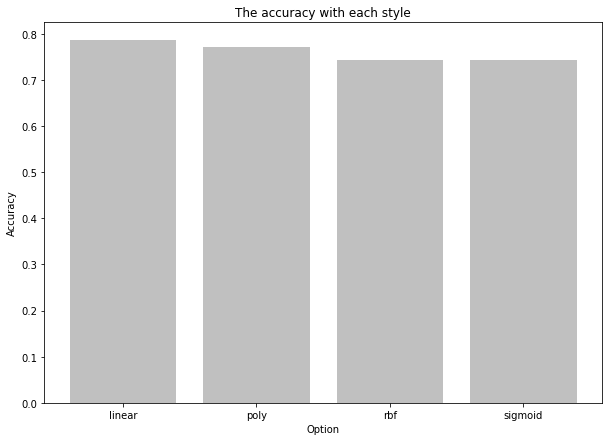

In [204]:
# Visualize the data.
plt.figure(figsize=(10,7))
plt.bar(styles
       ,accScores
       ,color = "silver")
plt.title("The accuracy with each style")
plt.ylabel("Accuracy")
plt.xlabel("Option")

In [31]:
print("The best style is linear")
bestSvmModel = svm.SVC(kernel="linear").fit(X_train,y_train)

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_train, bestSvmModel.predict(X_train),pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, bestSvmModel.predict(X_test),pos_label="PAIDOFF"))

print("Train set Accuracy (F1): ", f1_score(y_train, bestSvmModel.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, bestSvmModel.predict(X_test), average='weighted'))

The best style is linear
Train set Accuracy (Jaccard):  0.7427536231884058
Test set Accuracy (Jaccard):  0.7857142857142857
Train set Accuracy (F1):  0.6331163939859591
Test set Accuracy (F1):  0.6914285714285714


# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [33]:
optimizers = ['lbfgs', 'saga', 'liblinear', 'newton-cg', 'sag']
for o in optimizers:
    lr = LogisticRegression(C =.01,solver=o).fit(X_train,y_train)
    lrYhat = lr.predict(X_test)
    yProb = lr.predict_proba(X_test)
    print("When the optimizer is",o,", the logloss is",log_loss(y_test,yProb))

When the optimizer is lbfgs , the logloss is 0.4920179847937498
When the optimizer is saga , the logloss is 0.4920180696053802
When the optimizer is liblinear , the logloss is 0.5772287609479654
When the optimizer is newton-cg , the logloss is 0.4920178014679269
When the optimizer is sag , the logloss is 0.49201439067030056


In [34]:
print("As you can see, the best optimizer is liblinear.")
bestLgModel = LogisticRegression(C = 0.01, solver = 'liblinear').fit(X_train, y_train)

from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

print("Train set Accuracy (Jaccard): ", jaccard_score(y_train, bestLgModel.predict(X_train),pos_label="PAIDOFF"))
print("Test set Accuracy (Jaccard): ", jaccard_score(y_test, bestLgModel.predict(X_test),pos_label="PAIDOFF"))

print("Train set Accuracy (F1): ", f1_score(y_train, bestLgModel.predict(X_train), average='weighted'))
print("Test set Accuracy (F1): ", f1_score(y_test, bestLgModel.predict(X_test), average='weighted'))

As you can see, the best optimizer is liblinear.
Train set Accuracy (Jaccard):  0.7351778656126482
Test set Accuracy (Jaccard):  0.6764705882352942
Train set Accuracy (F1):  0.7341146337750953
Test set Accuracy (F1):  0.6670522459996144


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-13 05:33:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-13 05:33:23 (72.9 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [37]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [38]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)


x_loan_test = Feature1
x_loan_test = preprocessing.StandardScaler().fit(x_loan_test).transform(x_loan_test)

y_loan_test = test_df['loan_status'].values

test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [39]:
# Predicted values of each model
knYhat = bestKnModel.predict(x_loan_test)
treeYhat = bestLoanTree.predict(x_loan_test)
svmYhat = bestSvmModel.predict(x_loan_test)
lgYhat = bestLgModel.predict(x_loan_test)

# Get the Jaccard value for each model.
yHatVals = [knYhat,treeYhat,svmYhat,lgYhat]
jaccVals = []
f1Vals = []
for vals in yHatVals:
    jaccVals.append(round(jaccard_score(y_loan_test,vals,pos_label="PAIDOFF"),2))
    f1Vals.append(round(f1_score(y_loan_test,vals,average="weighted"),2))
print(f1Vals,'\n',jaccVals)

# Log Loss
llVals = ["NA","NA","NA",round(log_loss(y_loan_test,bestLgModel.predict_proba(x_loan_test)),2)]


[0.63, 0.63, 0.63, 0.66] 
 [0.65, 0.74, 0.74, 0.74]


In [40]:
# Create the new Dataset.
columns = ["K-Neighbors","Decision Tree","SVM","Logistic Regression"]

accDf = pd.DataFrame([jaccVals,f1Vals,llVals],columns=columns)
accDf=accDf.transpose()
accDf.columns=["F1","Jaccard","Log-Loss"]
accDf.columns.name = "Algorithm"
accDf

Algorithm,F1,Jaccard,Log-Loss
K-Neighbors,0.65,0.63,NA
Decision Tree,0.74,0.63,NA
SVM,0.74,0.63,NA
Logistic Regression,0.74,0.66,0.57


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>